### Kelly Tornetta
### Decision Tree with Titanic Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

### Importing Data

In [57]:
df = pd.read_csv('Titanic.csv')
df.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [58]:
df.columns

Index(['Unnamed: 0', 'pclass', 'survived', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body',
       'home.dest'],
      dtype='object')

In [11]:
df = df.drop(['Unnamed: 0', 'name', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'], axis = 'columns')

In [12]:
df.head()

,pclass,survived,sex,age,sibsp
0,1st,1,female,29.0000,0
1,1st,1,male,0.9167,1
2,1st,0,female,2.0000,1
3,1st,0,male,30.0000,1
4,1st,0,female,25.0000,1


### Missing Data

In [16]:
df.isnull().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
dtype: int64

In [17]:
df["age"] = df["age"].fillna(df["age"].median())

In [18]:
df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
dtype: int64

### Format Data

In [20]:
X = df.drop('survived', axis = 'columns').copy()
X.head()

,pclass,sex,age,sibsp
0,1st,female,29.0000,0
1,1st,male,0.9167,1
2,1st,female,2.0000,1
3,1st,male,30.0000,1
4,1st,female,25.0000,1


In [24]:
y = df['survived'].copy()
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

In [27]:
df.dtypes

pclass       object
survived      int64
sex          object
age         float64
sibsp         int64
dtype: object

In [25]:
df['pclass'].unique()

array(['1st', '2nd', '3rd'], dtype=object)

In [26]:
df['sex'].unique()

array(['female', 'male'], dtype=object)

In [28]:
X_encoded = pd.get_dummies(X, columns = ['pclass', 'sex'])
X_encoded.head()

,age,sibsp,pclass_1st,pclass_2nd,pclass_3rd,sex_female,sex_male
0,29.0000,0,1,0,0,1,0
1,0.9167,1,1,0,0,0,1
2,2.0000,1,1,0,0,1,0
3,30.0000,1,1,0,0,0,1
4,25.0000,1,1,0,0,1,0


In [29]:
y.unique()

array([1, 0])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2)

### Build First Tree

I built the first decision tree and plotted it (it's HUGE). Clearly the decision tree is overfitted here. Looking at the confusion matrices for test data and train data, we see the following:

in‐sample percent survivors correctly predicted (on training set): $\frac{304}{304+94} = 76.4\% $

in-sample percent fatalities correctly predicted (on training set): $\frac{620}{620+29} = 95.5\%$

out‐of‐sample percent survivors correctly predicted (on test set): $\frac{59}{59+43} = 57.8\%$

out-of‐sample percent fatalities correctly predicted (on test set): $\frac{139}{139+21} = 86.9\%$

In [31]:
clf_dt = DecisionTreeClassifier()
clf_dt = clf_dt.fit(X_train, y_train)

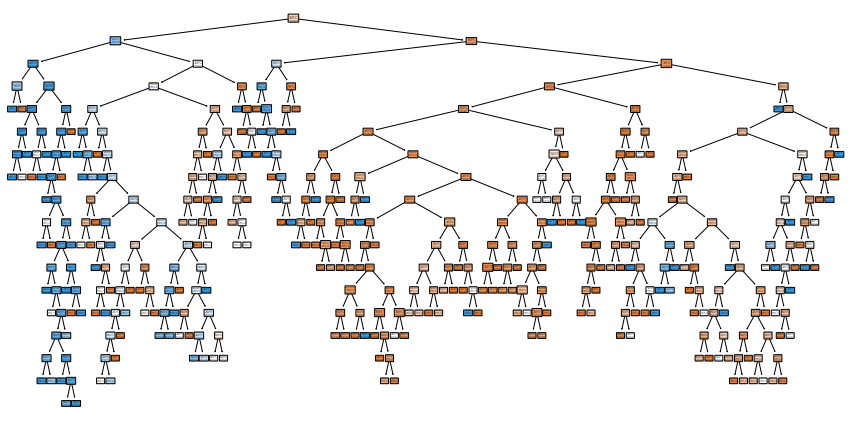

In [32]:
plt.figure(figsize = (15, 7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Died", "Survived"],
         feature_names = X_encoded.columns);

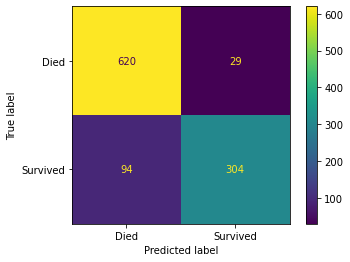

In [34]:
plot_confusion_matrix(clf_dt, X_train, y_train, display_labels = ["Died", "Survived"])

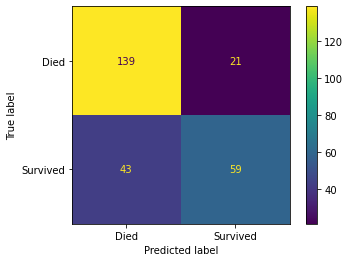

In [35]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels = ["Died", "Survived"])

### Prune Tree - Find Best ccp_alpha

To prune the tree, the parameter I chose to optimize was ccp_alpha: the cost complexity parameter. Greater values of ccp_alpha will increase the number of nodes pruned, thus creating a tree that generalizes better. Finding the best ccp_alpha will result with the optimal height and number of nodes for our decision tree. 

From scikit-learn.org: "Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves."

Using this method, I plotted all ccp_alphas except for the maximum alpha since it would result in the decision tree being the single root node. Then, I used 10-fold cross validation to pick the best ccp_alpha. I found that value to be $\alpha = 0.00185\dots$ to maximize the test accuracy.

In [36]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) #determine values for alpha
ccp_alphas = path.ccp_alphas 
ccp_alphas = ccp_alphas[:-1] #remove max alpha which is just root node

clf_dts = [] #array for decision trees
for ccp_alpha in ccp_alphas: #run through all ccp_alphas
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

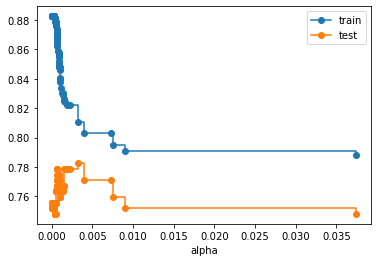

In [37]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test)  for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel = ("accuracy")
ax.set_title = ("Accuracy vs alpha for decision trees")
ax.plot(ccp_alphas, train_scores, marker = 'o', label = "train", drawstyle = "steps-post")
ax.plot(ccp_alphas, test_scores, marker = 'o', label = "test", drawstyle = "steps-post")
ax.legend()
plt.show()

### Prune Tree - Use 10-fold Cross Validation to Find Best ccp_alpha

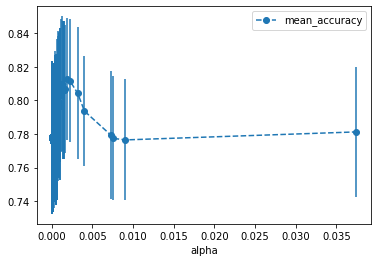

In [39]:
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv = 10)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values,
                            columns = ['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x = 'alpha',
                  y = 'mean_accuracy',
                  yerr = 'std',
                  marker = 'o',
                  linestyle = '--')

In [41]:
alpha_results[(alpha_results['alpha'] > 0.001)
             &
             (alpha_results['alpha'] < 0.004)]

,alpha,mean_accuracy,std
90,0.001013,0.803233,0.039781
91,0.001019,0.803233,0.039781
92,0.001062,0.804185,0.039117
93,0.001133,0.808947,0.039360
94,0.001306,0.809890,0.040242
95,0.001428,0.806053,0.041158
96,0.001430,0.806053,0.041158
97,0.001479,0.806053,0.041158
98,0.001480,0.806053,0.041158
99,0.001537,0.806053,0.038126


In [46]:
ideal_ccp_alpha = alpha_results['alpha'][101]
ideal_ccp_alpha

0.0018523596412007085

### Build Final Tree

Using $\alpha = 0.00185\dots$, I built and plotted the final decision tree. This tree is significantly smaller than the original, and the nodes are actually able to be read now! Looking at the new confusion matrices for test data and train data, we see the following:

in‐sample percent survivors correctly predicted (on training set): $\frac{281}{281+117} = 70.6\% $

in-sample percent fatalities correctly predicted (on training set): $\frac{580}{580+69} = 89.4\%$

out‐of‐sample percent survivors correctly predicted (on test set): $\frac{61}{61+41} = 59.8\%$

out-of‐sample percent fatalities correctly predicted (on test set): $\frac{143}{143+17} = 89.4\%$

The percent of correctly predicted training data decreased while the percent of correctly predicted testing data increased. This is because we are no longer overfitting. We can see that the fatality predictions are more accurate than the survivor predictions. This is likely due to there being significantly more fatalities than survivors. 

In [48]:
clf_dt_pruned = DecisionTreeClassifier(ccp_alpha = ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

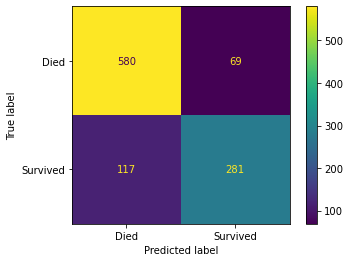

In [49]:
plot_confusion_matrix(clf_dt_pruned, X_train, y_train, display_labels = ["Died", "Survived"])

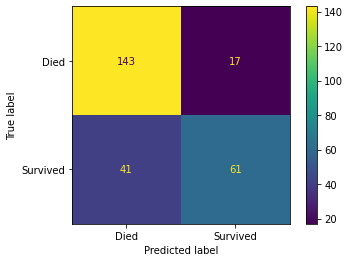

In [50]:
plot_confusion_matrix(clf_dt_pruned, X_test, y_test, display_labels = ["Died", "Survived"])

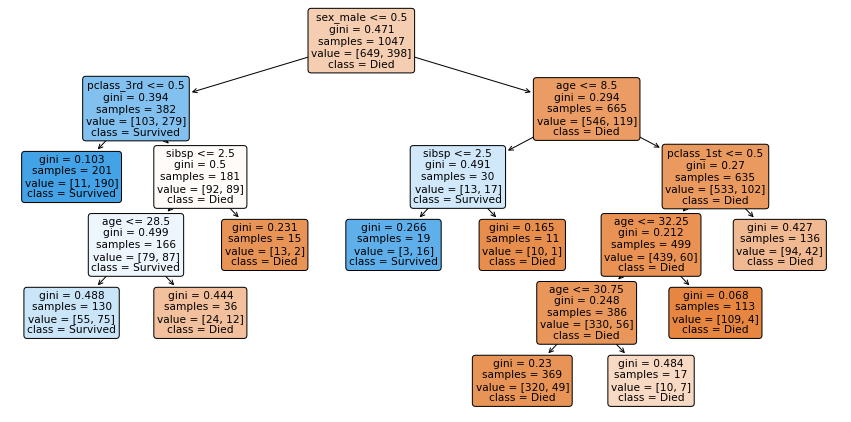

In [51]:
plt.figure(figsize = (15, 7.5))
plot_tree(clf_dt_pruned,
         filled = True,
         rounded = True,
         class_names = ["Died", "Survived"],
         feature_names = X_encoded.columns);